In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from numpy.linalg import inv
import math

In [2]:
def func(x):
    return np.sin(x)*(x-10)*(x-15)

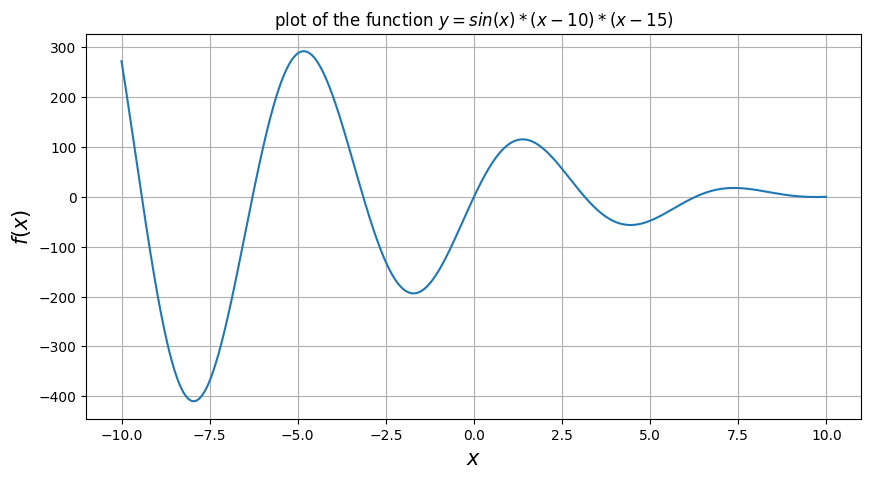

In [3]:
x = np.arange(-10, 10, 0.01)
plt.figure(figsize = (10,5))
plt.plot(x, func(x))
plt.title(r'plot of the function $y = sin(x) * (x - 10) * (x - 15)$')
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$f(x)$', fontsize = 15)
plt.grid(True)

In [5]:
x_k = np.arange(-10, 10, 1)
pr_func = np.array([func(i) for i in x_k])
print(pr_func)

[ 272.01055544 -187.92602927 -409.5943141  -245.71298792   93.88360739
  287.6772824   201.30946375  -33.02208189 -185.49667507 -148.09889333
    0.          106.02534409   94.56693239   11.85408068  -49.94896469
  -47.94621373  -10.05895794   15.76767837   13.85101545    2.47271091]


# Lagrange interpolation polynomial

In [6]:
def lagrange_basis(x_0, x: np.array, k):
    coef = 1.0
    for i in range(np.size(x)):
        if i != k:
            coef *= x_0 - x[i]
            coef /= x[k] - x[i]
    return coef


def lagrange_polynomial(x_0, pr_func: np.array, x: np.array):
    sum = 0.0
    for i in range(np.size(pr_func)):
        sum += pr_func[i] * lagrange_basis(x_0, x, i)
    return sum

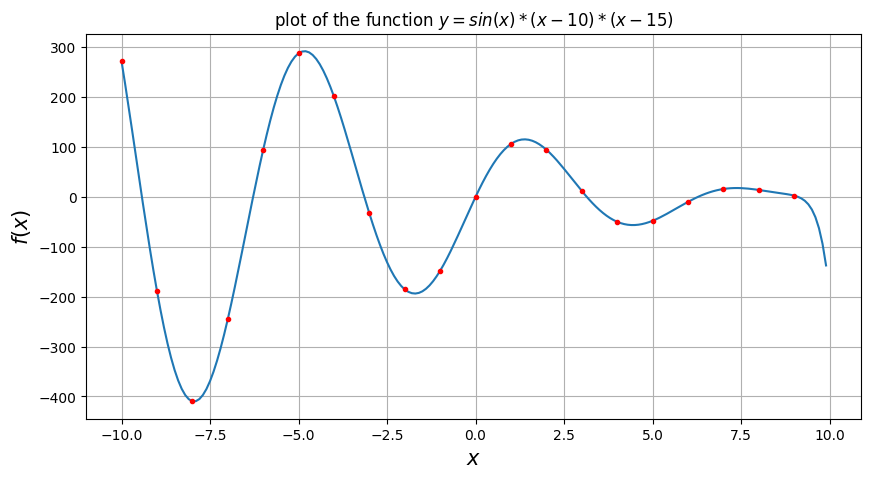

In [7]:
x = np.arange(-10.0, 10.0, 0.1)
plt.figure(figsize = (10,5))
plt.plot(x, lagrange_polynomial(x, pr_func, x_k), x_k, pr_func, 'r.')
plt.title(r'plot of the function $y = sin(x) * (x - 10) * (x - 15)$')
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$f(x)$', fontsize = 15)
plt.grid(True)
plt.show()

# Newton interpolation polynomial

In [8]:
def newton_basis(x: np.array, pr_func:np.array):
    n = len(pr_func)
    coef = np.zeros([n, n])
    coef[:,0] = pr_func
    
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j]-x[i])
            
    return coef

def newton_polynomial(x_0:np.array, coef:np.array, x:np.array):
    n = len(x) - 1 
    p = coef[n]
    for k in range(1, n + 1):
        p = coef[n - k] + (x_0 - x[n - k])*p
    return p

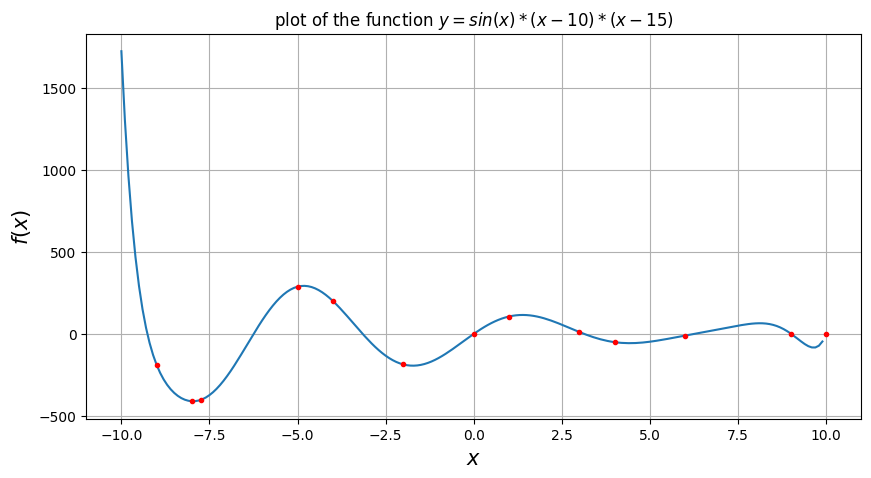

In [9]:
x_k = np.array([-9, -8, -7.75, -5, -4, -2, 0, 1, 3, 4, 6, 9, 10])
pr_func = np.array([func(i) for i in x_k])

x = np.arange(-10.0, 10.0, 0.1)
coef = newton_basis(x_k, pr_func)[0,:]
y = newton_polynomial(x, coef, x_k)
plt.figure(figsize = (10,5))
plt.plot(x, y, x_k, pr_func, 'r.')
plt.title(r'plot of the function $y = sin(x) * (x - 10) * (x - 15)$')
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$f(x)$', fontsize = 15)
plt.grid(True)
plt.show()

# Cubic Spline Interpolation

In [61]:
def swap_lines(A, f, i, k):
    temp = np.copy(A[i])
    A[i] = np.copy(A[k])
    A[k] = np.copy(temp)
    temp2 = np.copy(f[i])
    f[i] = np.copy(f[k])
    f[k] = np.copy(temp2)

def max_in_col(A, k, iter):
    max = -10
    num = -1
    size = np.size(A[0])
    for i in range(iter, size):
        if A[i, k] > max:
            num = i
            max = A[i, k]
    return num
           
def step(A, f, iter):
    size = np.size(A[0])
    num = max_in_col(A, iter, iter)
    swap_lines(A, f, iter, num)
    for i in range(0, size):
        if(i == iter):
            continue
        temp = (A[i, iter] / A[iter, iter]) * np.copy(A[iter])
        #print(temp)
        temp2 = (A[i, iter] / A[iter, iter]) * np.copy(f[iter])
        A[i] = A[i] - temp
        #print(A[i])
        f[i] = f[i] - temp2


def solve_gauss(A, f):
    size = np.size(A[0])
    for i in range(0, size):
        step(A, f, i)
    solution = np.array([f[i] / A[i, i] for i in range(0, size)])
    return solution


def cubic_spline(x, y):
    size = len(x)
    delta_x = np.diff(x)
    delta_y = np.diff(y)
    
    A = np.zeros([size, size])
    b = np.zeros([size, 1])
    A[0,0] = 1
    A[-1,-1] = 1
    
    for i in range(1, size - 1):
        A[i, i-1] = delta_x[i - 1]
        A[i, i+1] = delta_x[i]
        A[i, i] = 2 * (delta_x[ i- 1]+delta_x[i])

        b[i, 0] = 3 * (delta_y[i] / delta_x[i] - delta_y[i - 1] / delta_x[i - 1])
        
    c = solve_gauss(A, b)
    
    d = np.zeros([size - 1, 1])
    b = np.zeros([size - 1, 1])
    for i in range(0,len(d)):
        d[i] = (c[i + 1] - c[i]) / (3 * delta_x[i])
        b[i] = (delta_y[i] / delta_x[i]) - (delta_x[i] / 3) * (2 * c[i] + c[i + 1])    
    
    return b.squeeze(), c.squeeze(), d.squeeze()

def spline_polynomial(x_0, x_k, pr_func, b, c, d):
    index = -1
    for i in range(len(x_k) - 1):
        if x_k[i + 1] > x_0:
            index = i
            break
    p = pr_func[index] + b[index]*(x_0 - x_k[index]) + c[index]*(x_0 - x_k[index])**2 + d[index]*(x_0 - x_k[index])**3
    return p


In [64]:
x_k = np.array([-9, -8, -7.75, -5, -4, -2, 0, 1, 3, 4, 6, 9, 10])
pr_func = np.array([func(i) for i in x_k])

b, c, d = cubic_spline(x_k, pr_func)
x = np.arange(-10.0, 10.0, 0.1)
y = np.array([spline_polynomial(i, x_k, pr_func, b, c, d) for i in x])

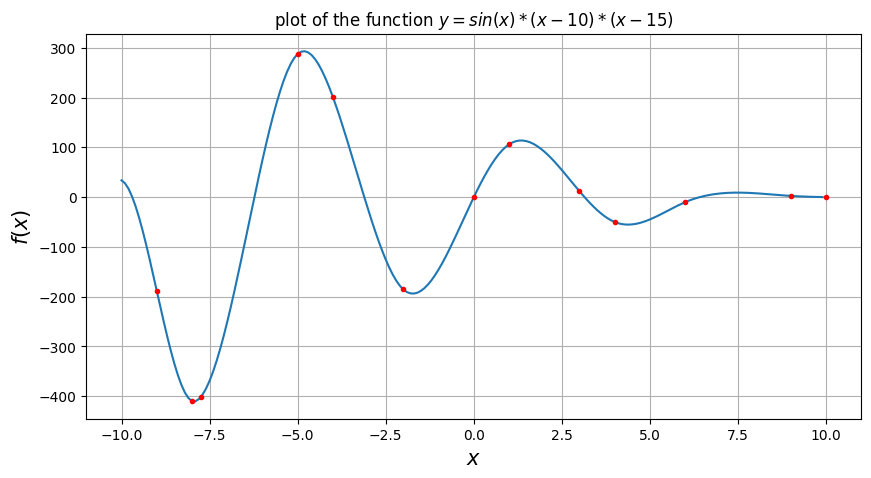

In [65]:
plt.figure(figsize = (10,5))
plt.plot(x, y, x_k, pr_func, 'r.')
plt.title(r'plot of the function $y = sin(x) * (x - 10) * (x - 15)$')
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$f(x)$', fontsize = 15)
plt.grid(True)
plt.show()

In [1]:
!git status

Текущая ветка: main
Эта ветка соответствует «origin/main».

Изменения, которые не в индексе для коммита:
  (используйте «git add <файл>...», чтобы добавить файл в индекс)
  (используйте «git restore <файл>...», чтобы отменить изменения в рабочем каталоге)
	изменено:      lab1.ipynb
	изменено:      lab2.ipynb
	изменено:      lab3.ipynb
	изменено:      lab4.ipynb

Неотслеживаемые файлы:
  (используйте «git add <файл>...», чтобы добавить в то, что будет включено в коммит)
	geeksforgeeks.png
	lab5.ipynb
	labdif.ipynb

индекс пуст (используйте «git add» и/или «git commit -a»)
